# GANs - MNIST Digit Dataset

![gan structure](https://miro.medium.com/max/1400/1*ZKUo2QtHasnr8-RiqeJ_YA.png)

### Helper Functions

In [1]:
### SCALE & NORMALIZE MNIST dataset ###
# Scale data from range [0-255] to [0-1]
# Normalize data to range [-1, 1]
def scale_norm(x):
    # Scale
    x = (x/255)
    # Normalize | Without unsqueeze_, Normalize() will throw a size error
    x = Normalize(mean=(0.5,), std=(0.5,))(x.unsqueeze_(0))
    x = x.squeeze_(0)   # Reverse engineering
    return x

In [2]:
### DENORMALIZE input ###
# 
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

### Import dependencies and dataset

In [3]:
import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Normalize, Compose, Lambda
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
train_set = MNIST(root='./data', 
                  train=True, 
                  download=True,
                   transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])
                 )

test_set = MNIST(root='./data', 
                  train=False, 
                  download=True,
                  transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])
                )

##########################################################
### We don't need to scale the data becase when we     ###
### sample batch from DataLoader, it is already scaled ###
### (But I'm keeping the code, it might comes handy)   ###
##########################################################

# print('Before Pre-processing\n======Train=========')
# print(f'Max: {torch.max(train_set.data)}, Min: {torch.min(train_set.data)}')
# print('======Test=========')
# print(f'Max: {torch.max(test_set.data)}, Min: {torch.min(test_set.data)}')

# train_set.data = scale_norm(train_set.data)
# test_set.data  = scale_norm(test_set.data)

# print('\nAfter Pre-processing\n======Train=========')
# print(f'Max: {torch.max(train_set.data)}, Min: {torch.min(train_set.data)}')
# print('======Test=========')
# print(f'Max: {torch.max(test_set.data)}, Min: {torch.min(test_set.data)}')

# print(f'\nTraining set: {train_set.data.shape}')
# print(f'Training set: {test_set.data.shape}')

batch_size = 64

train_dl = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_set, batch_size=batch_size, shuffle=True)

### Plot Some Training Data

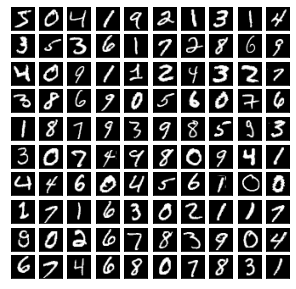

In [5]:
fig = plt.figure(figsize=(5, 5))
rows, columns = 10, 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(train_set.data[i-1], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


## Discriminator Model (D)

The discriminator takes an image as input, and tries to classify it as "real" or "generated". <br />
We can use a CNN for the discriminator, but for simplicity, for now we'll a feedforward network with 3 linear layers to keep things since. <br />
Every image is 28x28 matrix which can be flatten to a vector of size 784. <br />
`Input:784 -> NN:784 x hidden -> LeakyRelu(0.2) -> NN:hidden x hidden -> LeakyRelu(0.2) -> NN:hidden x 1 -> Sigmoid (output)` <br /> <br />
*'LeakyRelu' because we want the gradient to flow to the negative inputs as well*

In [7]:
hidden_size = 256

D = nn.Sequential(
        nn.Linear(784, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, 1),
        nn.Sigmoid()
    )
D.to(device)
print(D)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)


## Generator Model (G)

The input to the generator is typically a vector or a matrix which is used as a seed for generating an image. <br />
Once again, to keep things simple, we'll use a feedfoward neural network with 3 layers, and the output will be a vector of size 784, which can be transformed to a 28x28 matrix image. <br />
`Input:latent -> NN:latent x hidden -> Relu -> NN:hidden x hidden -> Relu -> NN: hidden x 784 -> TanH (output)` <br /> <br />
*'TanH' is a function's output ranging from -1 to 1 (which is exactly our data range)*

In [8]:
latent_size = 256

G = nn.Sequential(
        nn.Linear(latent_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, 784),
        nn.Tanh()
    )

G.to(device)
print(G)

Sequential(
  (0): Linear(in_features=256, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)


### Test the Generator Model
- Random 5 noises (Seeds) 
- Send to GPU `(because we sent G model to the gpu in the above cell)`
- denorm() the generated image `from [-1, 1] -> [0, 1]`
- torch view() is the same as reshape() in numpy
- detach() split the image (input) from its gradient
- Send back to CPU to plot `because matplotlib can't access data on the gpu`

torch.Size([5, 784])


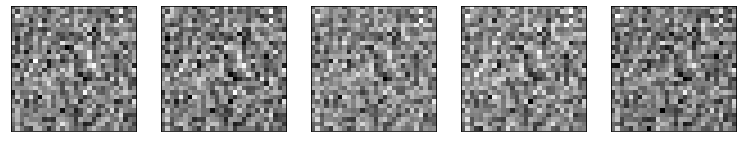

In [9]:
noise = torch.rand(5, latent_size).to(device)
gen_img = G(noise)
print(gen_img.shape)
gen_img = denorm(gen_img)
gen_img = gen_img.view(-1, 28, 28)

fig = plt.figure(figsize=(13, 5))
rows, columns = 1, 5
for i in range(1, columns*rows + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(gen_img[i-1].detach().cpu(), cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

## How The Model Will Be Trained
* ### Loss/Objective Function (Binary Cross Entropy)

#### For Discriminator
*The loss of Discriminator is the sum of the loss of giving prediction on real images and loss of giving prediction on fake images*
![BCE_real](./bce1.PNG)
*For Real Images (y=1):* <br />
`Here, y_hat is the prediction from the Discriminator Model (D)`
> - We want **y_hat = 1** (**D** is doing its job well) because then Loss = log(1) = 0 (no punishment) <br />
> - If **y_hat = 0.1** (**D** only has confidence of 10% of saying an image is real), then Loss = -log(0.1) = 2.3 (Punishment) <br />

---
![BCE_fake](./bce0.PNG)
*For Fake Images (y=0):*
> - We want **y_hat = 0** (**D** is confidence in predicting fake images)<br />
> - If **y_hat = 0.99** then Loss = -log(0.01) = 4.6 (Punishment)

In [10]:
criterion = nn.BCELoss()

In [11]:
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0003)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0003)

In [12]:
def reset_gradient():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [13]:
def train_discriminator(real_imgs):
    curr_batch_size = len(real_imgs)
    
    ##### Create labels (y) for real and fake batch #####
    label_real = torch.ones(curr_batch_size).to(device)   # y = 1
    label_fake = torch.zeros(curr_batch_size).to(device)  # y = 0
    
    reset_gradient()
    
    ##### Train on real images #####
    real_imgs = real_imgs.view(curr_batch_size, -1).to(device)
    pred_real_imgs = D(real_imgs)   # D's prediction on the real images
    pred_real_imgs = pred_real_imgs.view(-1)
    loss_real_imgs = criterion(pred_real_imgs, label_real) # Want y_hat = 1
    
    ##### Train on fake images #####
    noise = torch.randn(curr_batch_size, latent_size).to(device)
    fake_imgs = G(noise)   # Generate fake images
    pred_fake_imgs = D(fake_imgs) # D's prediction on fake images
    pred_fake_imgs = pred_fake_imgs.view(-1)
    loss_fake_imgs = criterion(pred_fake_imgs, label_fake) # We want y_hat = 0
    
    d_loss = loss_fake_imgs + loss_real_imgs
    d_loss.backward()     # Compute gradient w.r.t the Discriminator's parameters
    d_optimizer.step()
    return (d_loss, pred_real_imgs, pred_fake_imgs)

In [14]:
def train_generator():
    noise = torch.randn(batch_size, latent_size).to(device)
    reset_gradient()
    fake_imgs = G(noise)   # Generate fake images
    pred = D(fake_imgs)           # Get some predictions from D 
    pred = pred.view(-1)
    label = torch.ones(batch_size).to(device)
    
    ### The reason we use label (y = 1) is because we want
    ### G to generate images to fool D to predict that the fake image is 1
    g_loss = criterion(pred, label)
    g_loss.backward()
    g_optimizer.step()
    return (g_loss, fake_imgs)

## Save Progess While Training

In [15]:
import os

sample_directory = './mnist_gans/samples'
if not os.path.exists(sample_directory):
    os.makedirs(sample_directory)

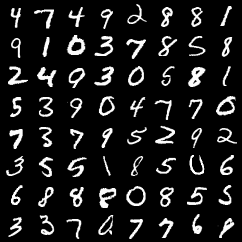

In [16]:
from IPython.display import Image
from torchvision.utils import save_image

# Save a batch of real images (8 imgs each row)
for imgs, _ in train_dl:
    save_image(denorm(imgs), os.path.join(sample_directory, 'real_images.png'), nrow=8)
    break

# Display Image
Image(os.path.join(sample_directory, 'real_images.png'))

Saving fake_images-0000.png


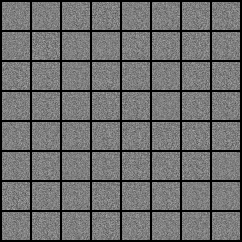

In [17]:
noise = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_imgs = G(noise)
    fake_imgs = fake_imgs.reshape(len(fake_imgs), 1, 28, 28)
    fake_img_name = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_img_name)
    save_image(denorm(fake_imgs), os.path.join(sample_directory, fake_img_name), nrow=8)
    
# # Before training
save_fake_images(0)
Image(os.path.join(sample_directory, 'fake_images-0000.png'))

In [18]:
# D returns (d_loss, pred_real_imgs, pred_fake_imgs)
# G returns (g_loss, fake_imgs)

## Train GANs

In [19]:
%%time

epochs = 300
total_steps = len(train_dl)
d_losses = []
g_losses = []
pred_reals = []
pred_fakes = []

save_on_epoch = [10, 50, 100, 150, 300]

for epoch in range(epochs):
    for i,  (imgs, _) in enumerate(train_dl):
        imgs = imgs.view(len(imgs), -1)
        
        d_loss, pred_real_imgs, pred_fake_imgs = train_discriminator(imgs)
        g_loss, fake_imgs = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            pred_reals.append(pred_real_imgs.mean().item())
            pred_fakes.append(pred_fake_imgs.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch+1, epochs, i+1, total_steps, d_loss.item(), g_loss.item(), 
                          pred_real_imgs.mean().item(), pred_fake_imgs.mean().item()))
            
    save_fake_images(epoch+1)
    if (epoch+1) in save_on_epoch:
        torch.save(D.state_dict(), f'./mnist_gans/model/D_gans_epoch{epoch}.pth')
        torch.save(G.state_dict(), f'./mnist_gans/model/G_gans_epoch{epoch}.pth')
        print(f'\t*** SAVED MODEL FOR EPOCH {epoch} ***')

Epoch [1/300], Step [200/938], d_loss: 0.0444, g_loss: 4.7488, D(x): 0.98, D(G(z)): 0.03
Epoch [1/300], Step [400/938], d_loss: 0.0612, g_loss: 5.8051, D(x): 0.98, D(G(z)): 0.03
Epoch [1/300], Step [600/938], d_loss: 0.2040, g_loss: 3.6361, D(x): 0.98, D(G(z)): 0.13
Epoch [1/300], Step [800/938], d_loss: 0.2738, g_loss: 3.6840, D(x): 0.91, D(G(z)): 0.09
Saving fake_images-0001.png
Epoch [2/300], Step [200/938], d_loss: 0.8857, g_loss: 2.9657, D(x): 0.89, D(G(z)): 0.44
Epoch [2/300], Step [400/938], d_loss: 0.7412, g_loss: 4.1553, D(x): 0.83, D(G(z)): 0.24
Epoch [2/300], Step [600/938], d_loss: 1.5734, g_loss: 1.4295, D(x): 0.60, D(G(z)): 0.42
Epoch [2/300], Step [800/938], d_loss: 0.5440, g_loss: 3.5656, D(x): 0.82, D(G(z)): 0.18
Saving fake_images-0002.png
Epoch [3/300], Step [200/938], d_loss: 0.7123, g_loss: 2.3861, D(x): 0.81, D(G(z)): 0.26
Epoch [3/300], Step [400/938], d_loss: 0.9122, g_loss: 2.2467, D(x): 0.71, D(G(z)): 0.21
Epoch [3/300], Step [600/938], d_loss: 1.1340, g_loss:

Epoch [22/300], Step [400/938], d_loss: 0.5780, g_loss: 3.8159, D(x): 0.81, D(G(z)): 0.12
Epoch [22/300], Step [600/938], d_loss: 0.6113, g_loss: 2.2835, D(x): 0.84, D(G(z)): 0.23
Epoch [22/300], Step [800/938], d_loss: 0.4202, g_loss: 3.5791, D(x): 0.90, D(G(z)): 0.18
Saving fake_images-0022.png
Epoch [23/300], Step [200/938], d_loss: 0.4261, g_loss: 3.8974, D(x): 0.84, D(G(z)): 0.11
Epoch [23/300], Step [400/938], d_loss: 0.4911, g_loss: 3.7804, D(x): 0.83, D(G(z)): 0.13
Epoch [23/300], Step [600/938], d_loss: 0.4727, g_loss: 3.3977, D(x): 0.85, D(G(z)): 0.16
Epoch [23/300], Step [800/938], d_loss: 0.5444, g_loss: 3.6154, D(x): 0.87, D(G(z)): 0.19
Saving fake_images-0023.png
Epoch [24/300], Step [200/938], d_loss: 0.5936, g_loss: 2.3122, D(x): 0.90, D(G(z)): 0.24
Epoch [24/300], Step [400/938], d_loss: 0.3682, g_loss: 4.5823, D(x): 0.84, D(G(z)): 0.06
Epoch [24/300], Step [600/938], d_loss: 0.3018, g_loss: 3.5664, D(x): 0.86, D(G(z)): 0.08
Epoch [24/300], Step [800/938], d_loss: 0.63

Epoch [43/300], Step [600/938], d_loss: 0.6952, g_loss: 2.0246, D(x): 0.75, D(G(z)): 0.21
Epoch [43/300], Step [800/938], d_loss: 0.7689, g_loss: 1.9951, D(x): 0.74, D(G(z)): 0.26
Saving fake_images-0043.png
Epoch [44/300], Step [200/938], d_loss: 1.0196, g_loss: 2.0506, D(x): 0.65, D(G(z)): 0.26
Epoch [44/300], Step [400/938], d_loss: 0.6738, g_loss: 2.4033, D(x): 0.80, D(G(z)): 0.26
Epoch [44/300], Step [600/938], d_loss: 0.7770, g_loss: 2.1862, D(x): 0.75, D(G(z)): 0.22
Epoch [44/300], Step [800/938], d_loss: 0.9163, g_loss: 1.9183, D(x): 0.72, D(G(z)): 0.30
Saving fake_images-0044.png
Epoch [45/300], Step [200/938], d_loss: 1.0915, g_loss: 1.4329, D(x): 0.71, D(G(z)): 0.34
Epoch [45/300], Step [400/938], d_loss: 0.6428, g_loss: 2.6248, D(x): 0.76, D(G(z)): 0.21
Epoch [45/300], Step [600/938], d_loss: 0.7026, g_loss: 2.4090, D(x): 0.71, D(G(z)): 0.19
Epoch [45/300], Step [800/938], d_loss: 0.9480, g_loss: 1.5432, D(x): 0.66, D(G(z)): 0.25
Saving fake_images-0045.png
Epoch [46/300], 

Epoch [64/300], Step [800/938], d_loss: 0.8079, g_loss: 1.3747, D(x): 0.74, D(G(z)): 0.30
Saving fake_images-0064.png
Epoch [65/300], Step [200/938], d_loss: 0.8173, g_loss: 2.1980, D(x): 0.75, D(G(z)): 0.29
Epoch [65/300], Step [400/938], d_loss: 0.8323, g_loss: 1.9246, D(x): 0.68, D(G(z)): 0.23
Epoch [65/300], Step [600/938], d_loss: 0.7948, g_loss: 2.3050, D(x): 0.77, D(G(z)): 0.31
Epoch [65/300], Step [800/938], d_loss: 0.9243, g_loss: 2.0798, D(x): 0.75, D(G(z)): 0.35
Saving fake_images-0065.png
Epoch [66/300], Step [200/938], d_loss: 0.8410, g_loss: 1.3303, D(x): 0.72, D(G(z)): 0.27
Epoch [66/300], Step [400/938], d_loss: 0.9556, g_loss: 1.5951, D(x): 0.71, D(G(z)): 0.33
Epoch [66/300], Step [600/938], d_loss: 0.9740, g_loss: 1.7662, D(x): 0.70, D(G(z)): 0.32
Epoch [66/300], Step [800/938], d_loss: 0.9233, g_loss: 1.5183, D(x): 0.71, D(G(z)): 0.29
Saving fake_images-0066.png
Epoch [67/300], Step [200/938], d_loss: 0.7575, g_loss: 2.7177, D(x): 0.71, D(G(z)): 0.20
Epoch [67/300], 

Saving fake_images-0085.png
Epoch [86/300], Step [200/938], d_loss: 0.8122, g_loss: 1.7091, D(x): 0.73, D(G(z)): 0.25
Epoch [86/300], Step [400/938], d_loss: 0.8741, g_loss: 1.2393, D(x): 0.73, D(G(z)): 0.33
Epoch [86/300], Step [600/938], d_loss: 0.7514, g_loss: 1.5040, D(x): 0.74, D(G(z)): 0.25
Epoch [86/300], Step [800/938], d_loss: 0.7397, g_loss: 1.4982, D(x): 0.76, D(G(z)): 0.28
Saving fake_images-0086.png
Epoch [87/300], Step [200/938], d_loss: 1.0871, g_loss: 1.3999, D(x): 0.72, D(G(z)): 0.42
Epoch [87/300], Step [400/938], d_loss: 0.8160, g_loss: 1.9741, D(x): 0.66, D(G(z)): 0.23
Epoch [87/300], Step [600/938], d_loss: 0.9819, g_loss: 1.6223, D(x): 0.69, D(G(z)): 0.26
Epoch [87/300], Step [800/938], d_loss: 1.1761, g_loss: 1.2126, D(x): 0.70, D(G(z)): 0.40
Saving fake_images-0087.png
Epoch [88/300], Step [200/938], d_loss: 1.0773, g_loss: 1.8032, D(x): 0.70, D(G(z)): 0.36
Epoch [88/300], Step [400/938], d_loss: 0.9467, g_loss: 1.6457, D(x): 0.63, D(G(z)): 0.22
Epoch [88/300], 

Saving fake_images-0106.png
Epoch [107/300], Step [200/938], d_loss: 0.8327, g_loss: 1.4625, D(x): 0.73, D(G(z)): 0.31
Epoch [107/300], Step [400/938], d_loss: 0.9632, g_loss: 2.3820, D(x): 0.64, D(G(z)): 0.21
Epoch [107/300], Step [600/938], d_loss: 0.9030, g_loss: 1.5405, D(x): 0.63, D(G(z)): 0.24
Epoch [107/300], Step [800/938], d_loss: 0.9025, g_loss: 1.3753, D(x): 0.71, D(G(z)): 0.33
Saving fake_images-0107.png
Epoch [108/300], Step [200/938], d_loss: 0.8509, g_loss: 1.4386, D(x): 0.66, D(G(z)): 0.26
Epoch [108/300], Step [400/938], d_loss: 0.8349, g_loss: 1.2334, D(x): 0.77, D(G(z)): 0.34
Epoch [108/300], Step [600/938], d_loss: 0.9854, g_loss: 1.4537, D(x): 0.71, D(G(z)): 0.34
Epoch [108/300], Step [800/938], d_loss: 0.8418, g_loss: 1.9966, D(x): 0.72, D(G(z)): 0.30
Saving fake_images-0108.png
Epoch [109/300], Step [200/938], d_loss: 0.9238, g_loss: 1.3103, D(x): 0.71, D(G(z)): 0.34
Epoch [109/300], Step [400/938], d_loss: 0.8935, g_loss: 1.8771, D(x): 0.68, D(G(z)): 0.31
Epoch 

Saving fake_images-0127.png
Epoch [128/300], Step [200/938], d_loss: 0.8152, g_loss: 1.6839, D(x): 0.65, D(G(z)): 0.19
Epoch [128/300], Step [400/938], d_loss: 0.7260, g_loss: 1.5621, D(x): 0.74, D(G(z)): 0.27
Epoch [128/300], Step [600/938], d_loss: 1.0253, g_loss: 1.4101, D(x): 0.64, D(G(z)): 0.33
Epoch [128/300], Step [800/938], d_loss: 1.1014, g_loss: 1.7743, D(x): 0.62, D(G(z)): 0.30
Saving fake_images-0128.png
Epoch [129/300], Step [200/938], d_loss: 0.9833, g_loss: 1.6462, D(x): 0.61, D(G(z)): 0.25
Epoch [129/300], Step [400/938], d_loss: 0.7857, g_loss: 1.7621, D(x): 0.71, D(G(z)): 0.25
Epoch [129/300], Step [600/938], d_loss: 0.8152, g_loss: 1.5951, D(x): 0.75, D(G(z)): 0.31
Epoch [129/300], Step [800/938], d_loss: 1.0692, g_loss: 1.4732, D(x): 0.73, D(G(z)): 0.40
Saving fake_images-0129.png
Epoch [130/300], Step [200/938], d_loss: 0.9605, g_loss: 1.6154, D(x): 0.65, D(G(z)): 0.28
Epoch [130/300], Step [400/938], d_loss: 1.1087, g_loss: 1.6312, D(x): 0.71, D(G(z)): 0.41
Epoch 

Saving fake_images-0148.png
Epoch [149/300], Step [200/938], d_loss: 1.0561, g_loss: 1.4496, D(x): 0.80, D(G(z)): 0.45
Epoch [149/300], Step [400/938], d_loss: 0.8506, g_loss: 1.4423, D(x): 0.74, D(G(z)): 0.28
Epoch [149/300], Step [600/938], d_loss: 0.9446, g_loss: 1.4591, D(x): 0.74, D(G(z)): 0.38
Epoch [149/300], Step [800/938], d_loss: 0.8389, g_loss: 1.5735, D(x): 0.75, D(G(z)): 0.32
Saving fake_images-0149.png
Epoch [150/300], Step [200/938], d_loss: 0.8592, g_loss: 1.8687, D(x): 0.72, D(G(z)): 0.31
Epoch [150/300], Step [400/938], d_loss: 0.8867, g_loss: 1.8177, D(x): 0.67, D(G(z)): 0.22
Epoch [150/300], Step [600/938], d_loss: 0.9174, g_loss: 1.4092, D(x): 0.74, D(G(z)): 0.31
Epoch [150/300], Step [800/938], d_loss: 0.8046, g_loss: 1.7824, D(x): 0.70, D(G(z)): 0.26
Saving fake_images-0150.png
Epoch [151/300], Step [200/938], d_loss: 1.0545, g_loss: 1.5534, D(x): 0.61, D(G(z)): 0.25
Epoch [151/300], Step [400/938], d_loss: 0.7224, g_loss: 1.7631, D(x): 0.69, D(G(z)): 0.20
Epoch 

Saving fake_images-0169.png
Epoch [170/300], Step [200/938], d_loss: 1.0794, g_loss: 1.6908, D(x): 0.62, D(G(z)): 0.29
Epoch [170/300], Step [400/938], d_loss: 1.0900, g_loss: 2.1019, D(x): 0.54, D(G(z)): 0.16
Epoch [170/300], Step [600/938], d_loss: 0.8836, g_loss: 1.5566, D(x): 0.67, D(G(z)): 0.23
Epoch [170/300], Step [800/938], d_loss: 0.8846, g_loss: 1.7343, D(x): 0.75, D(G(z)): 0.34
Saving fake_images-0170.png
Epoch [171/300], Step [200/938], d_loss: 0.8145, g_loss: 1.7382, D(x): 0.76, D(G(z)): 0.30
Epoch [171/300], Step [400/938], d_loss: 0.7909, g_loss: 1.7799, D(x): 0.74, D(G(z)): 0.31
Epoch [171/300], Step [600/938], d_loss: 0.7742, g_loss: 1.8783, D(x): 0.70, D(G(z)): 0.25
Epoch [171/300], Step [800/938], d_loss: 0.9306, g_loss: 1.4958, D(x): 0.67, D(G(z)): 0.29
Saving fake_images-0171.png
Epoch [172/300], Step [200/938], d_loss: 0.9182, g_loss: 1.5642, D(x): 0.68, D(G(z)): 0.31
Epoch [172/300], Step [400/938], d_loss: 0.9038, g_loss: 1.5955, D(x): 0.63, D(G(z)): 0.23
Epoch 

Saving fake_images-0190.png
Epoch [191/300], Step [200/938], d_loss: 0.8370, g_loss: 1.8205, D(x): 0.73, D(G(z)): 0.29
Epoch [191/300], Step [400/938], d_loss: 0.7622, g_loss: 1.6780, D(x): 0.80, D(G(z)): 0.35
Epoch [191/300], Step [600/938], d_loss: 0.8896, g_loss: 1.6926, D(x): 0.79, D(G(z)): 0.36
Epoch [191/300], Step [800/938], d_loss: 0.9984, g_loss: 1.5398, D(x): 0.72, D(G(z)): 0.36
Saving fake_images-0191.png
Epoch [192/300], Step [200/938], d_loss: 0.9385, g_loss: 1.6627, D(x): 0.69, D(G(z)): 0.30
Epoch [192/300], Step [400/938], d_loss: 0.8761, g_loss: 1.6353, D(x): 0.74, D(G(z)): 0.32
Epoch [192/300], Step [600/938], d_loss: 1.0718, g_loss: 1.8735, D(x): 0.67, D(G(z)): 0.32
Epoch [192/300], Step [800/938], d_loss: 1.0782, g_loss: 1.1330, D(x): 0.76, D(G(z)): 0.41
Saving fake_images-0192.png
Epoch [193/300], Step [200/938], d_loss: 0.7901, g_loss: 1.3637, D(x): 0.72, D(G(z)): 0.27
Epoch [193/300], Step [400/938], d_loss: 0.6515, g_loss: 1.5247, D(x): 0.82, D(G(z)): 0.30
Epoch 

Saving fake_images-0211.png
Epoch [212/300], Step [200/938], d_loss: 0.8354, g_loss: 1.9616, D(x): 0.66, D(G(z)): 0.22
Epoch [212/300], Step [400/938], d_loss: 0.9608, g_loss: 1.4400, D(x): 0.78, D(G(z)): 0.41
Epoch [212/300], Step [600/938], d_loss: 0.8562, g_loss: 1.8653, D(x): 0.70, D(G(z)): 0.29
Epoch [212/300], Step [800/938], d_loss: 0.7292, g_loss: 2.0768, D(x): 0.80, D(G(z)): 0.29
Saving fake_images-0212.png
Epoch [213/300], Step [200/938], d_loss: 0.9020, g_loss: 1.3852, D(x): 0.77, D(G(z)): 0.35
Epoch [213/300], Step [400/938], d_loss: 0.8970, g_loss: 1.9393, D(x): 0.70, D(G(z)): 0.31
Epoch [213/300], Step [600/938], d_loss: 0.8478, g_loss: 1.6448, D(x): 0.66, D(G(z)): 0.21
Epoch [213/300], Step [800/938], d_loss: 1.0252, g_loss: 1.1679, D(x): 0.59, D(G(z)): 0.23
Saving fake_images-0213.png
Epoch [214/300], Step [200/938], d_loss: 0.8269, g_loss: 1.4355, D(x): 0.80, D(G(z)): 0.37
Epoch [214/300], Step [400/938], d_loss: 0.8706, g_loss: 1.6993, D(x): 0.72, D(G(z)): 0.30
Epoch 

Saving fake_images-0232.png
Epoch [233/300], Step [200/938], d_loss: 0.8994, g_loss: 1.8417, D(x): 0.74, D(G(z)): 0.33
Epoch [233/300], Step [400/938], d_loss: 0.8523, g_loss: 1.4843, D(x): 0.72, D(G(z)): 0.27
Epoch [233/300], Step [600/938], d_loss: 0.8324, g_loss: 1.4476, D(x): 0.75, D(G(z)): 0.32
Epoch [233/300], Step [800/938], d_loss: 0.8005, g_loss: 1.7241, D(x): 0.73, D(G(z)): 0.30
Saving fake_images-0233.png
Epoch [234/300], Step [200/938], d_loss: 0.8423, g_loss: 1.4908, D(x): 0.75, D(G(z)): 0.31
Epoch [234/300], Step [400/938], d_loss: 1.1546, g_loss: 1.6143, D(x): 0.70, D(G(z)): 0.32
Epoch [234/300], Step [600/938], d_loss: 1.0359, g_loss: 1.6932, D(x): 0.69, D(G(z)): 0.31
Epoch [234/300], Step [800/938], d_loss: 0.8415, g_loss: 1.6289, D(x): 0.67, D(G(z)): 0.19
Saving fake_images-0234.png
Epoch [235/300], Step [200/938], d_loss: 1.0775, g_loss: 1.2762, D(x): 0.66, D(G(z)): 0.34
Epoch [235/300], Step [400/938], d_loss: 1.0851, g_loss: 1.4060, D(x): 0.71, D(G(z)): 0.32
Epoch 

Saving fake_images-0253.png
Epoch [254/300], Step [200/938], d_loss: 0.8744, g_loss: 1.2604, D(x): 0.79, D(G(z)): 0.39
Epoch [254/300], Step [400/938], d_loss: 0.9539, g_loss: 1.6799, D(x): 0.76, D(G(z)): 0.32
Epoch [254/300], Step [600/938], d_loss: 0.8911, g_loss: 1.4928, D(x): 0.66, D(G(z)): 0.26
Epoch [254/300], Step [800/938], d_loss: 0.6986, g_loss: 1.7376, D(x): 0.77, D(G(z)): 0.23
Saving fake_images-0254.png
Epoch [255/300], Step [200/938], d_loss: 0.8670, g_loss: 1.7212, D(x): 0.70, D(G(z)): 0.29
Epoch [255/300], Step [400/938], d_loss: 0.9641, g_loss: 1.5423, D(x): 0.66, D(G(z)): 0.26
Epoch [255/300], Step [600/938], d_loss: 0.8888, g_loss: 1.3685, D(x): 0.74, D(G(z)): 0.30
Epoch [255/300], Step [800/938], d_loss: 0.8528, g_loss: 1.8132, D(x): 0.73, D(G(z)): 0.29
Saving fake_images-0255.png
Epoch [256/300], Step [200/938], d_loss: 0.7748, g_loss: 1.4464, D(x): 0.75, D(G(z)): 0.31
Epoch [256/300], Step [400/938], d_loss: 0.6681, g_loss: 1.7845, D(x): 0.73, D(G(z)): 0.20
Epoch 

Saving fake_images-0274.png
Epoch [275/300], Step [200/938], d_loss: 0.9118, g_loss: 1.4056, D(x): 0.70, D(G(z)): 0.27
Epoch [275/300], Step [400/938], d_loss: 0.7824, g_loss: 1.3613, D(x): 0.75, D(G(z)): 0.27
Epoch [275/300], Step [600/938], d_loss: 0.7531, g_loss: 1.7711, D(x): 0.73, D(G(z)): 0.25
Epoch [275/300], Step [800/938], d_loss: 0.7886, g_loss: 1.8198, D(x): 0.78, D(G(z)): 0.31
Saving fake_images-0275.png
Epoch [276/300], Step [200/938], d_loss: 0.8878, g_loss: 1.7569, D(x): 0.73, D(G(z)): 0.31
Epoch [276/300], Step [400/938], d_loss: 1.0337, g_loss: 1.8797, D(x): 0.68, D(G(z)): 0.31
Epoch [276/300], Step [600/938], d_loss: 0.7145, g_loss: 1.6917, D(x): 0.78, D(G(z)): 0.27
Epoch [276/300], Step [800/938], d_loss: 0.9195, g_loss: 1.7651, D(x): 0.82, D(G(z)): 0.38
Saving fake_images-0276.png
Epoch [277/300], Step [200/938], d_loss: 0.7421, g_loss: 1.6973, D(x): 0.78, D(G(z)): 0.29
Epoch [277/300], Step [400/938], d_loss: 1.0014, g_loss: 1.4410, D(x): 0.67, D(G(z)): 0.29
Epoch 

Saving fake_images-0295.png
Epoch [296/300], Step [200/938], d_loss: 0.9103, g_loss: 2.0421, D(x): 0.72, D(G(z)): 0.28
Epoch [296/300], Step [400/938], d_loss: 0.8319, g_loss: 1.1940, D(x): 0.71, D(G(z)): 0.25
Epoch [296/300], Step [600/938], d_loss: 0.7688, g_loss: 1.4362, D(x): 0.71, D(G(z)): 0.24
Epoch [296/300], Step [800/938], d_loss: 0.7173, g_loss: 1.8730, D(x): 0.75, D(G(z)): 0.26
Saving fake_images-0296.png
Epoch [297/300], Step [200/938], d_loss: 0.8203, g_loss: 2.1629, D(x): 0.71, D(G(z)): 0.26
Epoch [297/300], Step [400/938], d_loss: 0.8679, g_loss: 1.5623, D(x): 0.74, D(G(z)): 0.29
Epoch [297/300], Step [600/938], d_loss: 0.8941, g_loss: 2.1377, D(x): 0.72, D(G(z)): 0.31
Epoch [297/300], Step [800/938], d_loss: 0.8580, g_loss: 2.1378, D(x): 0.75, D(G(z)): 0.30
Saving fake_images-0297.png
Epoch [298/300], Step [200/938], d_loss: 0.8426, g_loss: 1.7080, D(x): 0.71, D(G(z)): 0.24
Epoch [298/300], Step [400/938], d_loss: 0.8889, g_loss: 1.7376, D(x): 0.64, D(G(z)): 0.19
Epoch 

## Make generated images as video

In [20]:
import cv2
from IPython.display import FileLink

vid_fname = 'gans_mnist.mp4'

files = [os.path.join(sample_directory, f) for f in os.listdir(sample_directory) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*'mp4v'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_mnist.mp4')

/home/sophot/Documents/gans_mnist.mp4

In [21]:
from IPython.display import Video
Video('gans_mnist.mp4')

In [22]:
%%HTML
<video width="320" height="240" controls>
  <source src="gans_mnist.mp4" type="video/mp4">
</video>